# Chapter 2 - Image Enhancement

Will go over methods to transform images, sharpening, blurring, etc.

JuliaImages are 2D arrays, with each pixel either a scalar (grayscale) or a 1D array (RGB)

In [1]:
using Images

In [2]:
function reload_cats()
    load("../sample-images/cats-3061372_640.jpg");
end

reload_cats (generic function with 1 method)

In [3]:
reload_cats()
img[1:1, 1:1, :]

LoadError: UndefVarError: img not defined

In this case, we see that it's an RGB image, 0-1 (scaled by 1/255). This works until you want to manipulate pixels, in which the `channelview` function needs to be invoked

In [4]:
using ImageView

In [5]:
ch_view = channelview(img)
ch_view

LoadError: UndefVarError: img not defined

With this mapping, then we can manipulate pixels. Try updating colors with value >0.7 to force to 0.9. This gives a fun "filter" effect.

In [6]:
ch_view[ch_view .> 0.7] .= 0.9
img

LoadError: UndefVarError: ch_view not defined

#### Converting numbers to colors

Start with a random array

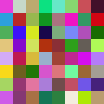

In [7]:
random_img = rand(3, 8, 8)
r_im = colorview(RGB, random_img)
r_im

Alternatively, if the order is mixed up, `permuteddimsview` exists to rearrange

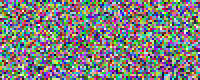

In [8]:
random_img_array = rand(40, 100, 3); # height, width, channel
img_perm = permuteddimsview(random_img_array, (3, 1, 2))
r_im = colorview(RGB, Float16.(img_perm))
r_im

### Saturation

To increase saturation, we'll increase the value 10%, clipping at 1.

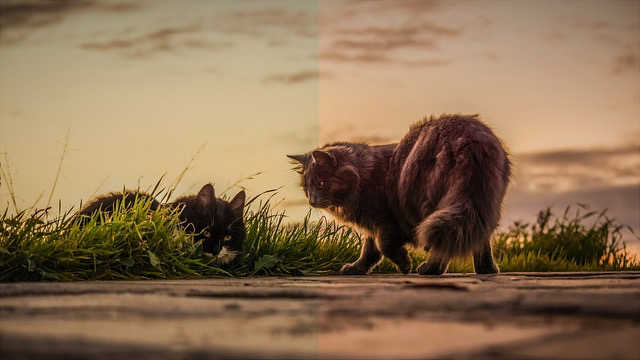

In [9]:
img = reload_cats() # Reload image
img_ch_view = channelview(img); # extract channels
img_ch_view = permuteddimsview(img_ch_view, (2, 3, 1)) # set channels to last dim
x_coords = Int(size(img, 2) /2):size(img,2 ); # Take the right half of the image
img_ch_view[:, x_coords, 1] = min.(img_ch_view[:, x_coords, 1] .* 1.1, 1) # Multiply by 1.1
img

Next, we'll try 20% to the green layer, then 40% to the blue channel

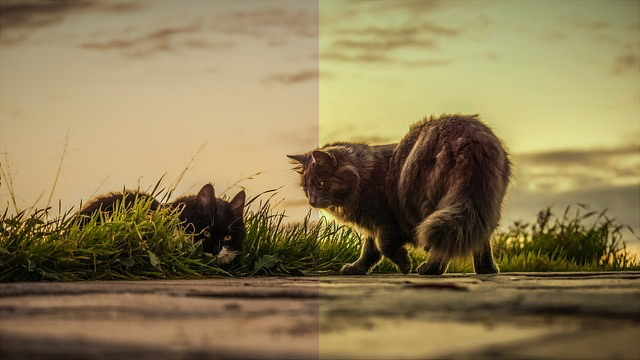

In [10]:
img_ch_view[:, x_coords, 2] = min.(img_ch_view[:, x_coords, 2] .* 1.2, 1) # Green
display(img)

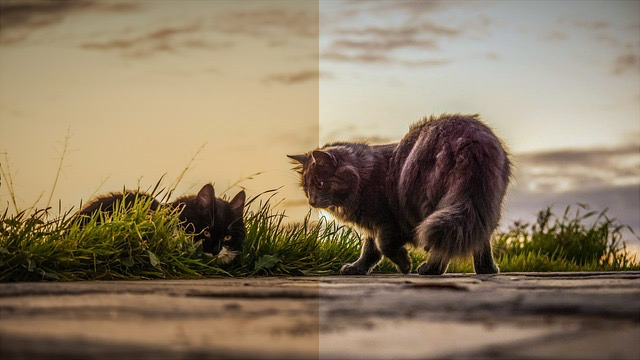

In [11]:
img_ch_view[:, x_coords, 3] = min.(img_ch_view[:, x_coords, 3] .* 1.4, 1) # Green
display(img)

### Converting to grayscale

This is pretty easy, there's a `Gray` function built in to images

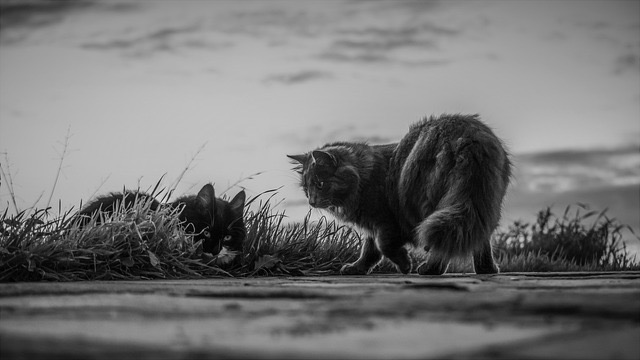

In [12]:
img = reload_cats()
grayscaled = Gray.(img)
display(grayscaled)

## Custom Filters

We can imagine more sophisticated filters. For example, perhaps we want to generate a color-splash filter.

We can do this by using a combination of gray and RGB mappings of the image. Then, use a mask to keep track of the pixels we want to keep based on their values.

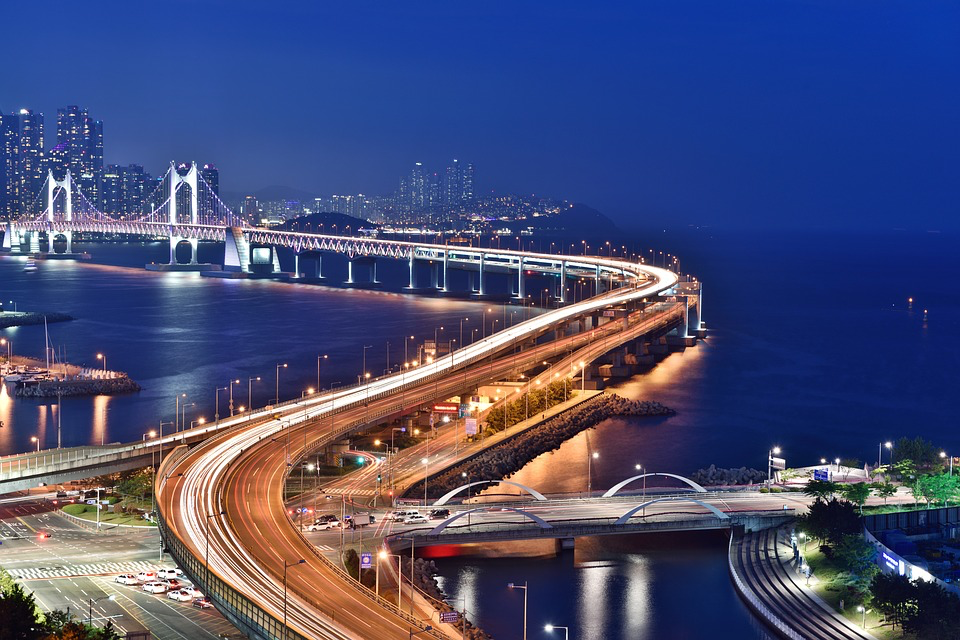

In [13]:
# Preview image
img = load("../sample-images/busan-night-scene.jpg")

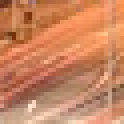

In [14]:
# Load the image, and a gray version
img_gray = RGB.(Gray.(img));

# Channel views
channel_view = channelview(img);
gray_channel_view = channelview(img_gray);

# Arrange correctly 
img_arr = permuteddimsview(channel_view, (2,3,1));
img_gray_arr = permuteddimsview(gray_channel_view, (2,3,1));

# Generate mask
img_mask = fill(true, size(img)) # all values start true
spot_height = 430:460  # Ranges with the colors we wnat to keep
spot_width = 430:460
img[spot_height, spot_width]

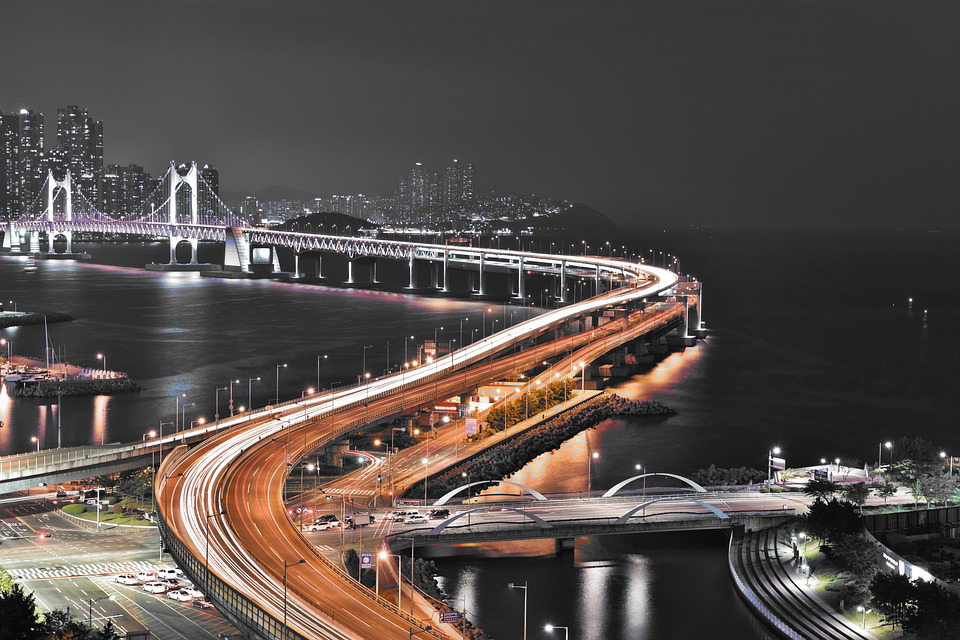

In [15]:
for channel_id = 1:3
    # Select current channel, crop to areas of interest
    curr_channel = view(img_arr, :, :, channel_id)
    current_channel_area = curr_channel[spot_height, spot_width, :]
    
    # Get max/min vals
    ch_min = minimum(current_channel_area)
    ch_max = maximum(current_channel_area)
    
    # Merge existing mask with current channel mask
    ch_mask = ch_min .< curr_channel .< ch_max
    img_mask = img_mask .& ch_mask
end

# Apply
img_masked = img_arr .* img_mask .+ img_gray_arr .* .~(img_mask);
final = colorview(RGB, permutedims(img_masked, (3,1,2)))
final